# GRU-Autoencoder followed by MLP Classifier

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Load data from Day-2
df_sheet1 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day2")

# Load data from Day-3
df_sheet2 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day3")

# Load data from Day-4
df_sheet3 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day4")

# Concatenate the data
df_combined = pd.concat([df_sheet1, df_sheet2, df_sheet3], ignore_index=True)


# Prepare Data
X = df_combined.iloc[:, 1:15].values  # Features (Process variables)
y = df_combined.iloc[:, 15].values    # Labels (Conditions)

In [36]:
# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [37]:
# Assuming X_train_scaled is your training data
seq_length = 3  # Choose your desired sequence length

# Reshape training data
def reshape_data(X_scaled, seq_length):
    num_samples, num_features = X_scaled.shape
    num_sequences = num_samples - seq_length + 1

    X_reshaped = np.zeros((num_sequences, seq_length, num_features))

    for i in range(num_sequences):
        X_reshaped[i, :, :] = X_scaled[i:i+seq_length, :]

    return X_reshaped

X_train_reshaped = reshape_data(X_train_scaled, seq_length)

# Reshape validation data
X_val_reshaped = reshape_data(X_val_scaled, seq_length)

# Reshape test data
X_test_reshaped = reshape_data(X_test_scaled, seq_length)

In [38]:
# Build GRU-Autoencoder Model 
model = Sequential(name="GRU-autoencoder")
model.add(Input(shape=(seq_length, X_train_scaled.shape[1]), name='Input-Layer'))

# Encoder Layers
model.add(Bidirectional(GRU(units=32, activation='relu', recurrent_activation='sigmoid', stateful=False,return_sequences=True), name='Hidden-GRU-Encoder-Layer-1'))
model.add(Bidirectional(GRU(units=16, activation='relu', recurrent_activation='sigmoid', stateful=False,return_sequences=True), name='Hidden-GRU-Encoder-Layer-2'))
model.add(Bidirectional(GRU(units=8, activation='relu', recurrent_activation='sigmoid', stateful=False,return_sequences=True), name='Hidden-GRU-Encoder-Layer-3'))

# Decoder Layers
model.add(Bidirectional(GRU(units=8, activation='relu', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer-1'))
model.add(Bidirectional(GRU(units=16, activation='relu', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer-2'))
model.add(Bidirectional(GRU(units=32, activation='relu', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer-3'))
model.add(TimeDistributed(Dense(units=X_train_reshaped.shape[2], activation='linear'), name='Output-Layer'))


In [39]:
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error (MSE) loss for reconstruction

# Train the Model
model.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=32, validation_data=(X_val_reshaped, X_val_reshaped))

Epoch 1/50
1136/1136 [==============================] - 23s 11ms/step - loss: 0.1725 - val_loss: 0.0382
Epoch 2/50
1136/1136 [==============================] - 12s 10ms/step - loss: 0.0269 - val_loss: 0.0211
Epoch 3/50
1136/1136 [==============================] - 12s 10ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 4/50
1136/1136 [==============================] - 12s 10ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 5/50
1136/1136 [==============================] - 12s 10ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 6/50
1136/1136 [==============================] - 12s 11ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 7/50
1136/1136 [==============================] - 12s 11ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 8/50
1136/1136 [==============================] - 13s 11ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/50
1136/1136 [==============================] - 12s 10ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 10/50
1136/1136 [==============================] - 12s 10m

Model: "GRU-autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer-1  (None, 3, 64)             9216      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Encoder-Layer-2  (None, 3, 32)             7872      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Encoder-Layer-3  (None, 3, 16)             2016      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Decoder-Layer-1  (None, 3, 16)             1248      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Decoder-Layer-2  (None, 3, 32)         

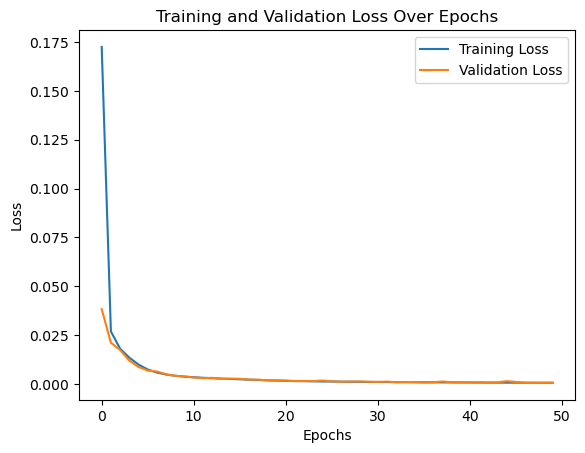

In [40]:
model.summary()


# Plot Training and Validation Loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [41]:
# Extract Encoder Part (Dimensionality Reduction)
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

# Display Encoder Architecture
encoder.summary()


# Transform Data using the Encoder
X_train_encoded = encoder.predict(X_train_reshaped)
X_val_encoded = encoder.predict(X_val_reshaped)
X_test_encoded = encoder.predict(X_test_reshaped)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 3, 14)]           0         
                                                                 
 Hidden-GRU-Encoder-Layer-1  (None, 3, 64)             9216      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Encoder-Layer-2  (None, 3, 32)             7872      
  (Bidirectional)                                                
                                                                 
 Hidden-GRU-Encoder-Layer-3  (None, 3, 16)             2016      
  (Bidirectional)                                                
                                                                 
Total params: 19104 (74.62 KB)
Trainable params: 19104 (74.62 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [42]:
# Convert sequence data back to normal form for classification
def pick_first_samples(X_sequence):
    num_sequences, seq_length, num_features = X_sequence.shape
    # For the last sequence, consider all samples
    flattened = X_sequence[:-1, 0, :].reshape(-1, num_features)
    # For the last sequence, consider all samples
    flattened = np.vstack([flattened, X_sequence[-1, :, :].reshape(-1, num_features)])
    return flattened

# Apply on training, validation and testing data
X_train_flat_picked = pick_first_samples(X_train_encoded)
X_val_flat_picked = pick_first_samples(X_val_encoded)
X_test_flat_picked = pick_first_samples(X_test_encoded)

In [43]:
# Classifier Model
classifier = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)

# Train the classifier
classifier.fit(X_train_flat_picked, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)

In [44]:
# Get the learned coefficients and intercepts
coefficients = classifier.coefs_
intercepts = classifier.intercepts_

# Calculate the number of parameters
num_parameters = sum(np.prod(coef.shape) for coef in coefficients) + sum(len(intercept) for intercept in intercepts)

print(f"Number of trainable parameters: {num_parameters}")

Number of trainable parameters: 12677


In [45]:
# Predictions on validation set
y_val_pred = classifier.predict(X_val_flat_picked)

# Calculate accuracy on validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val:.4f}")

Validation Accuracy: 0.9833


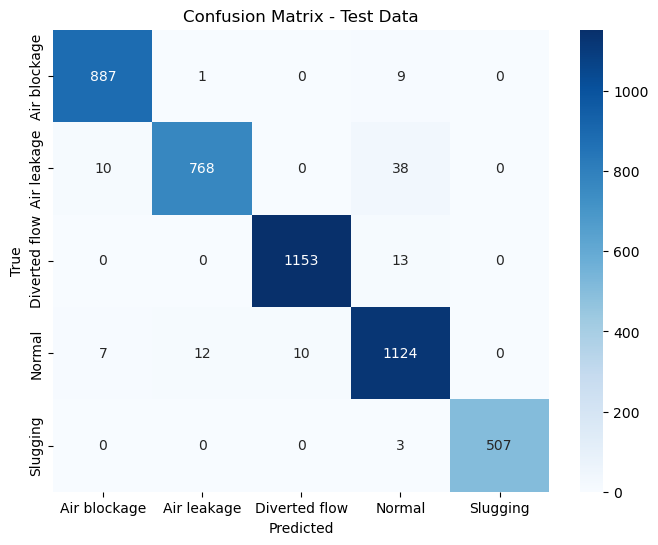

Test Accuracy: 0.9773
Precision: 0.9776
Recall: 0.9773
F1 Score: 0.9773
Classification Report:
                precision    recall  f1-score   support

 Air blockage       0.98      0.99      0.99       897
  Air leakage       0.98      0.94      0.96       816
Diverted flow       0.99      0.99      0.99      1166
       Normal       0.95      0.97      0.96      1153
     Slugging       1.00      0.99      1.00       510

     accuracy                           0.98      4542
    macro avg       0.98      0.98      0.98      4542
 weighted avg       0.98      0.98      0.98      4542



In [46]:
# Predictions on test set
y_test_pred = classifier.predict(X_test_flat_picked)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1-score on test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", class_report)